In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = "./data/"
    
filename = os.path.join(path,"network_intrusion_data.csv")
df = pd.read_csv(filename, na_values=['NA','?'], header=None)
df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]
#df=df[0:200000]

In [3]:
binary_convert = lambda x: 0 if x == "normal." else 1
df_binary_array=df['outcome'].apply(binary_convert)
df_binary = pd.DataFrame({'out_binary': df_binary_array})
# result = pd.concat([df,df_binary], axis=1, sort=False)
# result[700:745]
result=df;
result = result.drop(columns=['outcome'])
#Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
out_binary = le.fit_transform(df_binary)
out_binary[730:745]
print(result[0:5])

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot            ...             dst_host_count  \
0               0       0    0            ...                          9   
1               0       0    0            ...                         19   
2               0       0    0            ...                         29   
3               0       0    0            ...                         39   
4               0       0    0            ...                         49   

   dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                   9                     1.0    

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<h4>OneHotEncoding : Categorical Features</h4>

In [4]:
protocol_type = le.fit_transform(result['protocol_type'])
df_protocol_type = pd.DataFrame(protocol_type, columns=['one_hot_encoded'])
encode_text_dummy(df_protocol_type, 'one_hot_encoded')
one_hot_protocol_type = df_protocol_type.values

service = le.fit_transform(result['service'])
df_service = pd.DataFrame(service, columns=['one_hot_encoded'])
encode_text_dummy(df_service, 'one_hot_encoded')
one_hot_service = df_service.values

flag = le.fit_transform(result['flag'])
df_flag = pd.DataFrame(flag, columns=['one_hot_encoded'])
encode_text_dummy(df_flag, 'one_hot_encoded')
one_hot_flag = df_flag.values

land = le.fit_transform(result['land'])
df_land = pd.DataFrame(land, columns=['one_hot_encoded'])
encode_text_dummy(df_land, 'one_hot_encoded')
one_hot_land = df_land.values

logged_in = le.fit_transform(result['logged_in'])
df_logged_in = pd.DataFrame(logged_in, columns=['one_hot_encoded'])
encode_text_dummy(df_logged_in, 'one_hot_encoded')
one_hot_logged_in = df_logged_in.values

root_shell = le.fit_transform(result['root_shell'])
df_root_shell = pd.DataFrame(root_shell, columns=['one_hot_encoded'])
encode_text_dummy(df_root_shell, 'one_hot_encoded')
one_hot_root_shell = df_root_shell.values

su_attempted = le.fit_transform(result['su_attempted'])
df_su_attempted = pd.DataFrame(su_attempted, columns=['one_hot_encoded'])
encode_text_dummy(df_su_attempted, 'one_hot_encoded')
one_hot_su_attempted = df_su_attempted.values


is_host_login = le.fit_transform(result['is_host_login'])
df_is_host_login = pd.DataFrame(is_host_login, columns=['one_hot_encoded'])
encode_text_dummy(df_is_host_login, 'one_hot_encoded')
one_hot_is_host_login = df_is_host_login.values


is_guest_login = le.fit_transform(result['is_guest_login'])
df_is_guest_login = pd.DataFrame(is_guest_login, columns=['one_hot_encoded'])
encode_text_dummy(df_is_guest_login, 'one_hot_encoded')
one_hot_is_guest_login = df_is_guest_login.values

In [5]:
df_result=result.copy()

In [6]:
one_hot_combine = np.concatenate([one_hot_protocol_type, one_hot_service, one_hot_flag, one_hot_land, one_hot_logged_in
, one_hot_root_shell, one_hot_su_attempted, one_hot_is_host_login, one_hot_is_guest_login],axis=1)

print(one_hot_combine.shape)

(494021, 92)


<h3>Numeric Feature Normalization</h3>

In [7]:
df_result['normalize_duration']=zscore(df_result['duration'])
df_result['normalize_src_bytes'] = zscore(df_result['src_bytes'])
df_result['normalize_dst_bytes'] = zscore(df_result['dst_bytes'])

df_result['normalize_wrong_fragment'] = zscore(df_result['wrong_fragment'])
df_result['normalize_urgent'] = zscore(df_result['urgent'])
df_result['normalize_hot'] = zscore(df_result['hot'])

df_result['normalize_num_failed_logins']=zscore(df_result['num_failed_logins'])
df_result['normalize_logged_in'] = zscore(df_result['logged_in'])
df_result['normalize_num_compromised']=zscore(df_result['num_compromised'])

df_result['normalize_num_root'] = zscore(df_result['num_root'])
df_result['normalize_num_file_creations'] = zscore(df_result['num_file_creations'])
df_result['normalize_num_shells'] = zscore(df_result['num_shells'])

df_result['normalize_num_access_files'] = zscore(df_result['num_access_files'])

# df_result['normalize_num_outbound_cmds'] = zscore(df_result['num_outbound_cmds']) All values are zero in this so unable for zscore

df_result['normalize_count'] = zscore(df_result['count'])

df_result['normalize_srv_count'] = zscore(df_result['srv_count'])
df_result['normalize_serror_rate'] = zscore(df_result['serror_rate'])
df_result['normalize_srv_serror_rate']=zscore(df_result['srv_serror_rate'])

df_result['normalize_rerror_rate'] = zscore(df_result['rerror_rate'])
df_result['normalize_srv_rerror_rate']=zscore(df_result['srv_rerror_rate'])
df_result['normalize_same_srv_rate'] = zscore(df_result['same_srv_rate'])

df_result['normalize_diff_srv_rate'] = zscore(df_result['diff_srv_rate'])
df_result['normalize_srv_diff_host_rate']=zscore(df_result['srv_diff_host_rate'])
df_result['normalize_dst_host_count'] = zscore(df_result['dst_host_count'])

df_result['normalize_dst_host_srv_count'] = zscore(df_result['dst_host_srv_count'])
df_result['normalize_dst_host_same_srv_rate'] = zscore(df_result['dst_host_same_srv_rate'])
df_result['normalize_dst_host_diff_srv_rate'] = zscore(df_result['dst_host_diff_srv_rate'])

df_result['normalize_dst_host_same_src_port_rate'] = zscore(df_result['dst_host_same_src_port_rate'])
df_result['normalize_dst_host_srv_diff_host_rate'] = zscore(df_result['dst_host_srv_diff_host_rate'])
df_result['normalize_dst_host_serror_rate'] = zscore(df_result['dst_host_serror_rate'])

df_result['normalize_dst_host_srv_serror_rate'] = zscore(df_result['dst_host_srv_serror_rate'])
df_result['normalize_dst_host_rerror_rate'] = zscore(df_result['dst_host_rerror_rate'])
df_result['normalize_dst_host_srv_rerror_rate'] = zscore(df_result['dst_host_srv_rerror_rate'])

In [8]:
x1 = df_result['normalize_duration'].values.reshape( len(df_result['duration']),1)
x2 = df_result['normalize_src_bytes'].values.reshape( len(df_result['src_bytes']),1)
x3 = df_result['normalize_dst_bytes'].values.reshape( len(df_result['dst_bytes']),1)

x4 = df_result['normalize_wrong_fragment'].values.reshape( len(df_result['wrong_fragment']),1)
x5 = df_result['normalize_urgent'].values.reshape( len(df_result['urgent']),1)
x6 = df_result['normalize_hot'].values.reshape( len(df_result['hot']),1)

x7 = df_result['normalize_num_failed_logins'].values.reshape( len(df_result['num_failed_logins']),1)
x8 = df_result['normalize_logged_in'].values.reshape( len(df_result['logged_in']),1)
x9 = df_result['normalize_num_compromised'].values.reshape( len(df_result['num_compromised']),1)

x10 = df_result['normalize_num_root'].values.reshape( len(df_result['num_root']),1)
x11 = df_result['normalize_num_file_creations'].values.reshape( len(df_result['num_file_creations']),1)
x12 = df_result['normalize_num_shells'].values.reshape( len(df_result['num_shells']),1)

x13 = df_result['normalize_num_access_files'].values.reshape( len(df_result['num_access_files']),1)

# df_result['normalize_num_outbound_cmds'].values.reshape( len(df_result['num_outbound_cmds']),1) All values are zero in this so unable for zscore

x14 = df_result['normalize_count'].values.reshape( len(df_result['count']),1)

x15 = df_result['normalize_srv_count'].values.reshape( len(df_result['srv_count']),1)
x16 = df_result['normalize_serror_rate'].values.reshape( len(df_result['serror_rate']),1)
x17 = df_result['normalize_srv_serror_rate'].values.reshape( len(df_result['srv_serror_rate']),1)

x18 = df_result['normalize_rerror_rate'].values.reshape( len(df_result['rerror_rate']),1)
x19 = df_result['normalize_srv_rerror_rate'].values.reshape( len(df_result['srv_rerror_rate']),1)
x20 = df_result['normalize_same_srv_rate'].values.reshape( len(df_result['same_srv_rate']),1)

x21 = df_result['normalize_diff_srv_rate'].values.reshape( len(df_result['diff_srv_rate']),1)
x22 = df_result['normalize_srv_diff_host_rate'].values.reshape( len(df_result['srv_diff_host_rate']),1)
x23 = df_result['normalize_dst_host_count'].values.reshape( len(df_result['dst_host_count']),1)

x24 = df_result['normalize_dst_host_srv_count'].values.reshape( len(df_result['dst_host_srv_count']),1)
x25 = df_result['normalize_dst_host_same_srv_rate'].values.reshape( len(df_result['dst_host_same_srv_rate']),1)
x26 = df_result['normalize_dst_host_diff_srv_rate'].values.reshape( len(df_result['dst_host_diff_srv_rate']),1)

x27 = df_result['normalize_dst_host_same_src_port_rate'].values.reshape( len(df_result['dst_host_same_src_port_rate']),1)
x28 = df_result['normalize_dst_host_srv_diff_host_rate'].values.reshape( len(df_result['dst_host_srv_diff_host_rate']),1)
x29 = df_result['normalize_dst_host_serror_rate'].values.reshape( len(df_result['dst_host_serror_rate']),1)

x30 = df_result['normalize_dst_host_srv_serror_rate'].values.reshape( len(df_result['dst_host_srv_serror_rate']),1)
x31 = df_result['normalize_dst_host_rerror_rate'].values.reshape( len(df_result['dst_host_rerror_rate']),1)
x32 = df_result['normalize_dst_host_srv_rerror_rate'].values.reshape( len(df_result['dst_host_srv_rerror_rate']),1)
result[:10]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0
5,0,tcp,http,SF,217,2032,0,0,0,0,...,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0
6,0,tcp,http,SF,212,1940,0,0,0,0,...,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0
7,0,tcp,http,SF,159,4087,0,0,0,0,...,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0
8,0,tcp,http,SF,210,151,0,0,0,0,...,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0
9,0,tcp,http,SF,212,786,0,0,0,1,...,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0


In [9]:
print(out_binary[0:5])

[0 0 0 0 0]


In [10]:
#Onehot Encoding feature vectore
out_binary = le.fit_transform(df_binary)
df_out_binary = pd.DataFrame(out_binary, columns=['one_hot_encoded'])
encode_text_dummy(df_out_binary,'one_hot_encoded')
one_hot_out_binary = df_out_binary.values

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<h3>Fully-Connected Neural Networks</h3>

In [11]:
x = np.concatenate([one_hot_combine,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32],axis=1)
y = one_hot_out_binary
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42) 
print(y.shape)
print(x.shape)

(494021, 2)
(494021, 124)


In [12]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 395216 samples, validate on 98805 samples
Epoch 1/100
 - 13s - loss: 0.0068 - val_loss: 0.0041
Epoch 2/100
 - 13s - loss: 0.0035 - val_loss: 0.0035
Epoch 3/100
 - 13s - loss: 0.0030 - val_loss: 0.0036
Epoch 4/100
 - 14s - loss: 0.0028 - val_loss: 0.0058
Epoch 5/100
 - 14s - loss: 0.0027 - val_loss: 0.0035
Epoch 6/100
 - 14s - loss: 0.0040 - val_loss: 0.0042
Epoch 00006: early stopping
1
Train on 395216 samples, validate on 98805 samples
Epoch 1/100
 - 15s - loss: 0.0061 - val_loss: 0.0038
Epoch 2/100
 - 15s - loss: 0.0035 - val_loss: 0.0037
Epoch 3/100
 - 14s - loss: 0.0038 - val_loss: 0.0053
Epoch 4/100
 - 14s - loss: 0.0029 - val_loss: 0.0041
Epoch 5/100
 - 15s - loss: 0.0030 - val_loss: 0.0048
Epoch 6/100
 - 15s - loss: 0.0031 - val_loss: 0.0038
Epoch 00006: early stopping
2
Train on 395216 samples, validate on 98805 samples
Epoch 1/100
 - 15s - loss: 0.0060 - val_loss: 0.0053
Epoch 2/100
 - 14s - loss: 0.0034 - val_loss: 0.0045
Epoch 3/100
 - 14s - loss: 0.0032 - val_los

<h4>Confusion Matrix: Fully-Connected Neural Networks</h4>

[[19324    29]
 [   62 79390]]
Plotting confusion matrix


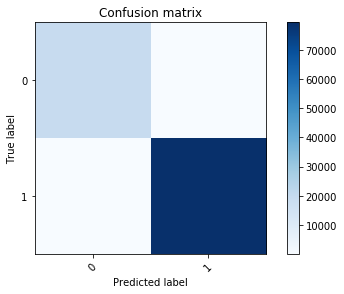

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19353
          1       1.00      1.00      1.00     79452

avg / total       1.00      1.00      1.00     98805

Precision :: 0.9990789939780376
Recall :: 0.9992196546342446
F1 Score :: 0.9994272082381302


In [13]:
out_binary = encode_text_index(df_binary,'out_binary')
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_true, pred))
print("Precision ::", metrics.accuracy_score(y_true, pred))
print("Recall ::", metrics.recall_score(y_true, pred))
print("F1 Score ::", metrics.f1_score(y_true, pred))

<h4>ROC curve for Neural Network</h4>

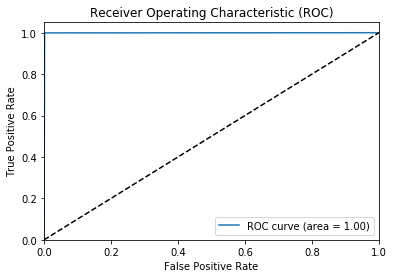

In [14]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(pred,y_true)

<h3>Logistic Regression</h3>

In [15]:
x = np.concatenate([one_hot_combine,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32],axis=1)
y=df_binary['out_binary']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42)
print(x.shape)
print(y.shape)


(494021, 124)
(494021,)


In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
Log_pred=logreg.predict(x_test)

# Measure accuracy
score = metrics.accuracy_score(y_test, Log_pred)
print("Final accuracy: {}".format(score))

<h4>Confusion Matrix: Logistic Regression</h4>

In [ ]:
out_binary = encode_text_index(df_binary,'out_binary')
# Compute confusion matrix
cm = confusion_matrix(y_test, Log_pred)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_test, Log_pred))
print("Precision :", metrics.accuracy_score(y_test, Log_pred))
print("Recall :", metrics.recall_score(y_test, Log_pred))
print("F1 Score :", metrics.f1_score(y_test, Log_pred))

<h4>ROC Curve: Logistic Regression</h4>

In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(Log_pred,y_test)

<h3>Nearest Neighbor</h3>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)
knn.fit(x_train, y_train)


In [ ]:
Knn_pred=knn.predict(x_test)  

# Measure accuracy
score = metrics.accuracy_score(y_test, Knn_pred)
print("Final accuracy: {}".format(score))

<h4>Confusion Matrix: Nearest Neighbor</h4>

In [ ]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

out_binary = encode_text_index(df_binary,'out_binary')
# Compute confusion matrix
cm = confusion_matrix(y_test, Knn_pred)
print(cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_test, Knn_pred))
print("Precision :", metrics.accuracy_score(y_test, Knn_pred))
print("Recall :", metrics.recall_score(y_test, Knn_pred))
print("F1 Score :", metrics.f1_score(y_test, Knn_pred))


<h4>ROC Curve: Nearest Neighbor</h4>

In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(Knn_pred,y_test)

<h3>Support Vector Machine</h3>

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train, y_train)  
svm_pred=clf.predict(x_test)

# Measure accuracy
score = metrics.accuracy_score(y_test, svm_pred)
print("Final accuracy: {}".format(score))

<h4>Confusion Matrix: Support Vector Machine</h4>

In [ ]:
out_binary = encode_text_index(df_binary,'out_binary')
# Compute confusion matrix
cm = confusion_matrix(y_test, svm_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_test, svm_pred))
print("Precision :", metrics.accuracy_score(y_test, svm_pred))
print("Recall :", metrics.recall_score(y_test, svm_pred))
print("F1 Score :", metrics.f1_score(y_test, svm_pred))

<h4>ROC Curve: Support Vector Machine</h4>

In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(svm_pred,y_test)

<h3>Gaussian Naive Bayes</h3>

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
#GaussianNB(priors=None, var_smoothing=1e-09)
clf_pf = GaussianNB()
clf_pf.partial_fit(x_train, y_train, np.unique(y_train))
#GaussianNB(priors=None, var_smoothing=1e-09)
gnb_pred = clf_pf.predict(x_test)
gnb_pred

<h4>Confusion Matrix: Gaussian Naive Bayes</h4>

In [ ]:
out_binary = encode_text_index(df_binary,'out_binary')
#Compute confusion matrix
cm = confusion_matrix(y_test, gnb_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_test, gnb_pred))
print("Precision :", metrics.accuracy_score(y_test, gnb_pred))
print("Recall :", metrics.recall_score(y_test, gnb_pred))
print("F1 Score :", metrics.f1_score(y_test, gnb_pred))
#print("Final accuracy: {}".format(score))

<h4>ROC Curve: Gaussian Naive Bayes</h4>

In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(gnb_pred,y_test)

<h3>Convolutional Neural Networks (CNN)</h3> trying 1D

In [ ]:
x = np.concatenate([one_hot_combine,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32],axis=1)
y = one_hot_out_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print(x.shape)
print(y.shape)

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D

cnn = Sequential()

cnn.add(Conv1D(64, kernel_size=5, strides=1, activation='tanh', input_shape=(x.shape[1],1)))

cnn.add(MaxPooling1D(pool_size=(2)))

cnn.add(Conv1D(128, kernel_size=10, strides=1, activation='tanh', input_shape=(47, 64)))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Conv1D(67, kernel_size=20, strides=1, activation='tanh', input_shape=(30, 128)))  
cnn.add(MaxPooling1D(pool_size=(1)))
cnn.add(Flatten())
cnn.add(Dense(1024, activation='tanh'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))
cnn.compile(loss="categorical_crossentropy", optimizer="rmsprop")

In [ ]:
import time

start_time = time.time()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

cnn.fit(x_train, y_train,
          batch_size=124,
          epochs=3,
          verbose=2,
          validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))
cnn.summary()

In [ ]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
cnn_pred = cnn.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)

score = metrics.accuracy_score(y_true, cnn_pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, cnn_pred))

<h4>Confusion Matrix: CNN</h4>

In [ ]:
out_binary = encode_text_index(df_binary,'out_binary')
#Compute confusion matrix
cm = confusion_matrix(y_true, cnn_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, out_binary)
plt.show()

print(classification_report(y_true, cnn_pred))
print("Precision :", metrics.accuracy_score(y_true, cnn_pred))
print("Recall :", metrics.recall_score(y_true, cnn_pred))
print("F1 Score :", metrics.f1_score(y_true, cnn_pred))

<h4>ROC Curve: CNN</h4>

In [ ]:
# Plot an ROC. pred - the predictions, y - the expected output.
plot_roc(cnn_pred,y_true)